In [1]:
# evaluate_pr_original.py

import xarray as xr
import numpy as np
import torch
import pickle
from pathlib import Path
from unet import UNet

# ----------------------------
# Configuration
# ----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = Path("data")
ckpt_dir = Path("ckpts")

# Variable configuration
variable = 'pr_hr'
var_base = 'pr'
var_lr = 'pr_lr_interp'

# Model to evaluate
model_name = 'pr_zscore_pixel_original'
norm_method = 'zscore_pixel'

# Test periods
test_periods = {
    'historical': ('2001', '2014'),
    'ssp126': ('2015', '2100'),
    'ssp245': ('2015', '2100'), 
    'ssp585': ('2015', '2100')
}

# ----------------------------
# Load data (NON-LOG versions)
# ----------------------------
print("Loading datasets (original, non-log-transformed)...")
ds_hist = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_historical_r1i1p1f1_1850_2014_allvars.nc")
ds_ssp126 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp126_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp245 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp245_r1i1p1f1_2015_2100_allvars.nc")
ds_ssp585 = xr.open_dataset(data_dir / "MPI-ESM1-2-HR-LR_ssp585_r1i1p1f1_2015_2100_allvars.nc")

datasets = {
    'historical': ds_hist,
    'ssp126': ds_ssp126,
    'ssp245': ds_ssp245,
    'ssp585': ds_ssp585
}

# Load normalization statistics (pixel-wise from original data)
print("Loading normalization statistics...")
with open(data_dir / "norm_stats_pr_pixelwise.pkl", 'rb') as f:
    norm_stats = pickle.load(f)

# ----------------------------
# Normalization helpers
# ----------------------------
def apply_zscore_pixel_normalization(data, norm_stats, var_base, resolution='lr_interp'):
    """Apply pixel-wise z-score normalization."""
    data_mean = norm_stats[var_base][resolution]['pixel_mean'].values
    data_std = norm_stats[var_base][resolution]['pixel_std'].values
    return (data.values - data_mean) / (data_std + 1e-8)

def denormalize_zscore_pixel(predictions, norm_stats, var_base):
    """Denormalize predictions back to original precipitation units (mm/day)."""
    hr_mean = norm_stats[var_base]['hr']['pixel_mean'].values
    hr_std = norm_stats[var_base]['hr']['pixel_std'].values
    return predictions * hr_std + hr_mean

# ----------------------------
# Model evaluation
# ----------------------------
def evaluate_model(model_path, dataset, test_period):
    """Evaluate the model on a dataset."""
    print(f"    Evaluating on {test_period[0]}-{test_period[1]}...")
    
    # Load model
    model = UNet(in_channels=1, out_channels=1, initial_features=32, depth=5, dropout=0.2)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    # Extract test data (in original mm/day units)
    lr_data = dataset[var_lr].sel(time=slice(test_period[0], test_period[1]))
    hr_data = dataset[variable].sel(time=slice(test_period[0], test_period[1]))
    
    # Apply pixel-wise z-score normalization to input
    lr_data_norm = apply_zscore_pixel_normalization(lr_data, norm_stats, var_base, resolution='lr_interp')
    
    # Predict in batches
    batch_size = 16
    n_samples = len(lr_data_norm)
    predictions = []
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = lr_data_norm[i:i+batch_size]
            batch_tensor = torch.tensor(batch, dtype=torch.float32).unsqueeze(1).to(device)
            
            # Get predictions
            batch_pred = model(batch_tensor)
            predictions.append(batch_pred.cpu().numpy())
    
    predictions = np.concatenate(predictions, axis=0).squeeze(1)
    
    # Denormalize predictions (back to original mm/day units)
    predictions_mmday = denormalize_zscore_pixel(predictions, norm_stats, var_base)
    hr_data_mmday = hr_data.values
    
    return predictions_mmday, hr_data_mmday, lr_data.values

# ----------------------------
# Main evaluation loop
# ----------------------------
print("\n" + "="*80)
print(f"EVALUATING PRECIPITATION MODEL: {model_name}")
print("="*80)

model_path = ckpt_dir / f"{model_name}.pth"

if not model_path.exists():
    print(f"ERROR: Model not found at {model_path}")
    exit(1)

print(f"Model path: {model_path}")
print(f"Normalization: {norm_method} (pixel-wise z-score)")
print(f"Data: Original (non-log-transformed)")

# Store all results
all_results = {}

for scenario_name, dataset in datasets.items():
    print(f"\n{scenario_name.upper()} Scenario")
    print("-"*40)
    
    test_period = test_periods[scenario_name]
    
    # Get ground truth and evaluate
    hr_data = dataset[variable].sel(time=slice(test_period[0], test_period[1]))
    lr_data = dataset[var_lr].sel(time=slice(test_period[0], test_period[1]))
    time_coords = hr_data.time
    lat_coords = hr_data.lat
    lon_coords = hr_data.lon
    
    # Evaluate model
    predictions, groundtruth, inputs = evaluate_model(model_path, dataset, test_period)
    
    # Create xarray DataArrays
    pred_da = xr.DataArray(
        predictions,
        coords={'time': time_coords, 'lat': lat_coords, 'lon': lon_coords},
        dims=['time', 'lat', 'lon'],
        name='pr_pred'
    )
    
    gt_da = xr.DataArray(
        groundtruth,
        coords={'time': time_coords, 'lat': lat_coords, 'lon': lon_coords},
        dims=['time', 'lat', 'lon'],
        name='pr_groundtruth'
    )
    
    input_da = xr.DataArray(
        inputs,
        coords={'time': time_coords, 'lat': lat_coords, 'lon': lon_coords},
        dims=['time', 'lat', 'lon'],
        name='pr_input'
    )
    
    all_results[scenario_name] = {
        'prediction': pred_da,
        'groundtruth': gt_da,
        'input': input_da
    }

# ----------------------------
# Save results
# ----------------------------
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

output_dir = Path("evaluation_results")
output_dir.mkdir(exist_ok=True)

for scenario_name, results in all_results.items():
    # Create dataset
    ds_result = xr.Dataset({
        'prediction': results['prediction'],
        'groundtruth': results['groundtruth'],
        'input': results['input']
    })
    
    # Add metadata
    ds_result.attrs['model'] = model_name
    ds_result.attrs['normalization'] = norm_method
    ds_result.attrs['data_type'] = 'original (non-log-transformed)'
    ds_result.attrs['units'] = 'mm/day'
    
    # Save to NetCDF
    output_path = output_dir / f"pr_evaluation_{model_name}_{scenario_name}.nc"
    ds_result.to_netcdf(output_path)
    print(f"  Saved: {output_path}")

# ----------------------------
# Compute metrics
# ----------------------------
print("\n" + "="*80)
print("EVALUATION METRICS")
print("="*80)

for scenario_name, results in all_results.items():
    pred = results['prediction'].values
    gt = results['groundtruth'].values
    
    # Compute metrics
    rmse = np.sqrt(np.mean((pred - gt)**2))
    mae = np.mean(np.abs(pred - gt))
    bias = np.mean(pred - gt)
    
    # Correlation
    pred_flat = pred.flatten()
    gt_flat = gt.flatten()
    corr = np.corrcoef(pred_flat, gt_flat)[0, 1]
    
    print(f"\n{scenario_name.upper()}:")
    print(f"  RMSE:        {rmse:.4f} mm/day")
    print(f"  MAE:         {mae:.4f} mm/day")
    print(f"  Bias:        {bias:.4f} mm/day")
    print(f"  Correlation: {corr:.4f}")
    print(f"  Pred range:  [{pred.min():.4f}, {pred.max():.4f}] mm/day")
    print(f"  GT range:    [{gt.min():.4f}, {gt.max():.4f}] mm/day")

print("\n" + "="*80)
print("EVALUATION COMPLETE!")
print("="*80)
print(f"Results saved in '{output_dir}/' directory")
print(f"All values are in mm/day (original units, non-log-transformed)")

/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home.ufs/yw4236/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading datasets (original, non-log-transformed)...
Loading normalization statistics...

EVALUATING PRECIPITATION MODEL: pr_zscore_pixel_original
Model path: ckpts/pr_zscore_pixel_original.pth
Normalization: zscore_pixel (pixel-wise z-score)
Data: Original (non-log-transformed)

HISTORICAL Scenario
----------------------------------------
    Evaluating on 2001-2014...

SSP126 Scenario
----------------------------------------
    Evaluating on 2015-2100...

SSP245 Scenario
----------------------------------------
    Evaluating on 2015-2100...

SSP585 Scenario
----------------------------------------
    Evaluating on 2015-2100...

SAVING RESULTS
  Saved: evaluation_results/pr_evaluation_pr_zscore_pixel_original_historical.nc
  Saved: evaluation_results/pr_evaluation_pr_zscore_pixel_original_ssp126.nc
  Saved: evaluation_results/pr_evaluation_pr_zscore_pixel_original_ssp245.nc
  Saved: evaluation_results/pr_evaluation_pr_zscore_pixel_original_ssp585.nc

EVALUATION METRICS

HISTORICAL:


In [19]:
all_data['historical'].groundtruth.std()

<xarray.DataArray 'groundtruth' ()> Size: 8B
array(21.01398468)

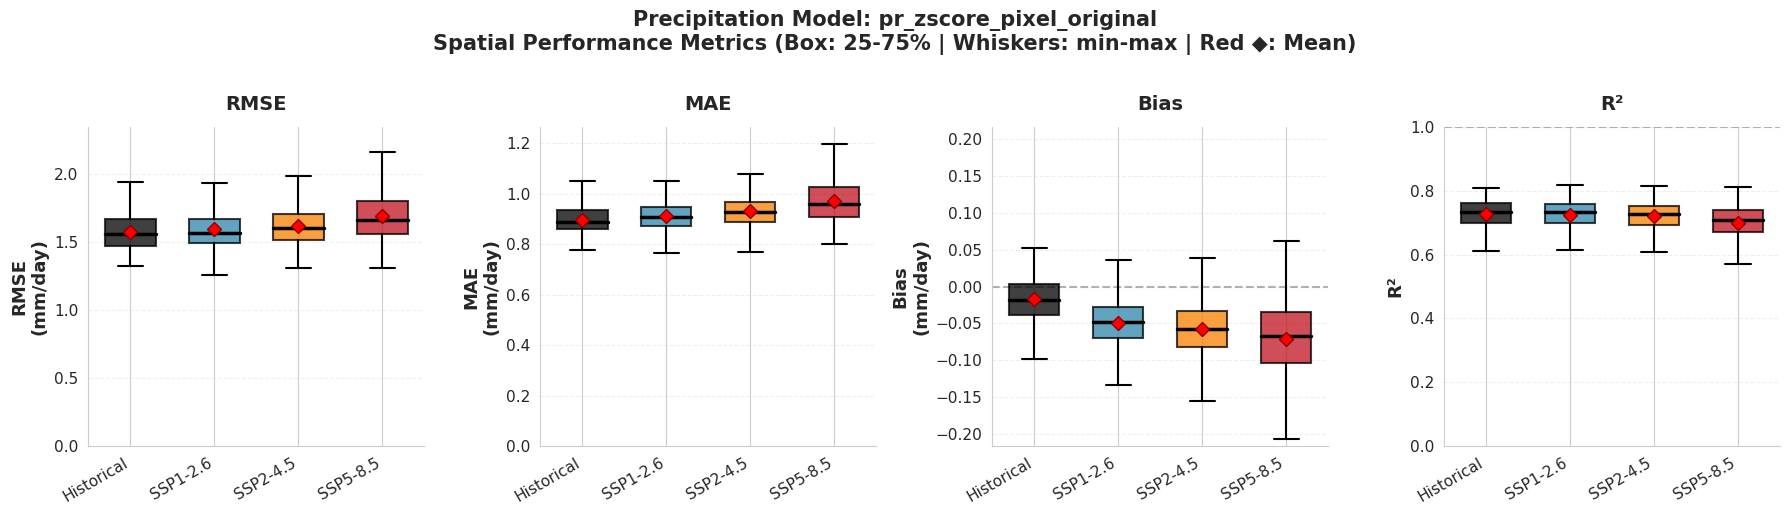

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
model_name = 'pr_zscore_pixel_original'

# Load all scenario results
all_data = {}
for scenario in scenarios:
    filepath = eval_dir / f"pr_evaluation_{model_name}_{scenario}.nc"
    if filepath.exists():
        ds = xr.open_dataset(filepath)
        all_data[scenario] = ds
    else:
        print(f"Warning: File not found - {filepath}")

def collect_spatial_metrics_timeseries(predictions, groundtruth):
    """
    Calculate spatial metrics for each time point.
    Returns arrays of metrics for each time step.
    """
    n_time = predictions.shape[0]
    rmse_values = []
    r2_values = []
    mae_values = []
    bias_values = []
    
    for t in range(n_time):
        pred_2d = predictions[t].flatten()
        gt_2d = groundtruth[t].flatten()
        
        # RMSE
        rmse = np.sqrt(np.mean((pred_2d - gt_2d)**2))
        rmse_values.append(rmse)
        
        # MAE
        mae = np.mean(np.abs(pred_2d - gt_2d))
        mae_values.append(mae)
        
        # Bias
        bias = np.mean(pred_2d - gt_2d)
        bias_values.append(bias)
        
        # R²
        if np.std(gt_2d) > 0:
            r2 = 1 - (np.sum((pred_2d - gt_2d)**2) / np.sum((gt_2d - np.mean(gt_2d))**2))
        else:
            r2 = np.nan
        r2_values.append(r2)
    
    return {
        'rmse': np.array(rmse_values),
        'mae': np.array(mae_values),
        'bias': np.array(bias_values),
        'r2': np.array(r2_values)
    }

# Scenario colors
scenario_colors = {
    'historical': '#000000',
    'ssp126': '#2E86AB',
    'ssp245': '#F77F00',
    'ssp585': '#C1121F'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Collect all metrics
metrics_data = {}

for scenario in scenarios:
    if scenario not in all_data:
        continue
    
    ds = all_data[scenario]
    
    # Get ground truth and prediction
    gt_data = ds['groundtruth'].values  # Shape: (time, lat, lon)
    pred_data = ds['prediction'].values  # Shape: (time, lat, lon)
    
    # Calculate metrics for each time step
    metrics = collect_spatial_metrics_timeseries(pred_data, gt_data)
    metrics_data[scenario] = metrics

# Create box plot figure (1 row × 4 metrics)
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

metric_info = [
    {'key': 'rmse', 'label': 'RMSE', 'unit': '(mm/day)', 'ylim': None, 'ref_line': None},
    {'key': 'mae', 'label': 'MAE', 'unit': '(mm/day)', 'ylim': None, 'ref_line': None},
    {'key': 'bias', 'label': 'Bias', 'unit': '(mm/day)', 'ylim': None, 'ref_line': 0.0},
    {'key': 'r2', 'label': 'R²', 'unit': '', 'ylim': (0.0, 1.0), 'ref_line': 1.0}
]

# Create box plots
for col, metric in enumerate(metric_info):
    ax = axes[col]
    
    # Prepare data for box plot
    box_data = []
    positions = []
    colors = []
    labels = []
    
    for i, scenario in enumerate(scenarios):
        if scenario in metrics_data:
            data = metrics_data[scenario][metric['key']]
            # Remove NaN values for R²
            if metric['key'] == 'r2':
                data = data[~np.isnan(data)]
            box_data.append(data)
            positions.append(i + 1)
            colors.append(scenario_colors[scenario])
            labels.append(scenario_labels[scenario])
    
    # Create box plot
    bp = ax.boxplot(box_data, positions=positions, widths=0.6,
                    patch_artist=True, showfliers=False,
                    medianprops=dict(color='black', linewidth=2.5),
                    boxprops=dict(linewidth=1.5),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.75)
    
    # Formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=11)
    
    # Set y-axis limits
    if metric['ylim'] is not None:
        ax.set_ylim(metric['ylim'])
    else:
        # Auto-scale
        if len(box_data) > 0:
            all_data_vals = np.concatenate(box_data)
            if metric['key'] == 'bias':
                # Symmetric around zero for bias
                max_abs = np.percentile(np.abs(all_data_vals), 99) * 1.2
                ax.set_ylim(-max_abs, max_abs)
            else:
                ax.set_ylim(0, np.percentile(all_data_vals, 99) * 1.1)
    
    # Y-axis label
    ylabel = f"{metric['label']}"
    if metric['unit']:
        ylabel += f"\n{metric['unit']}"
    ax.set_ylabel(ylabel, fontsize=13, fontweight='bold')
    
    # Title
    ax.set_title(metric['label'], fontsize=14, fontweight='bold', pad=12)
    
    # Grid
    ax.grid(True, alpha=0.3, axis='y', linestyle='--', linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Add mean marker (red diamond)
    for i, data_values in enumerate(box_data):
        mean_val = np.mean(data_values)
        ax.plot(positions[i], mean_val, 'D', color='red', 
               markersize=7, zorder=10, markeredgecolor='darkred', markeredgewidth=1)
    
    # Add reference line
    if metric['ref_line'] is not None:
        ax.axhline(y=metric['ref_line'], color='gray', linestyle='--', 
                  linewidth=1.5, alpha=0.6, zorder=1)
    
    ax.tick_params(labelsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Main title
fig.suptitle(f'Precipitation Model: {model_name}\n' + 
             'Spatial Performance Metrics (Box: 25-75% | Whiskers: min-max | Red ◆: Mean)',
             fontsize=15, fontweight='bold', y=1.02)

# Adjust layout
plt.tight_layout()

# # Save
# output_path = eval_dir / f'{model_name}_spatial_metrics_boxplot.png'
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
# print(f"Figure saved to: {output_path}")

plt.show()


/tmp/ipykernel_151237/587159213.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


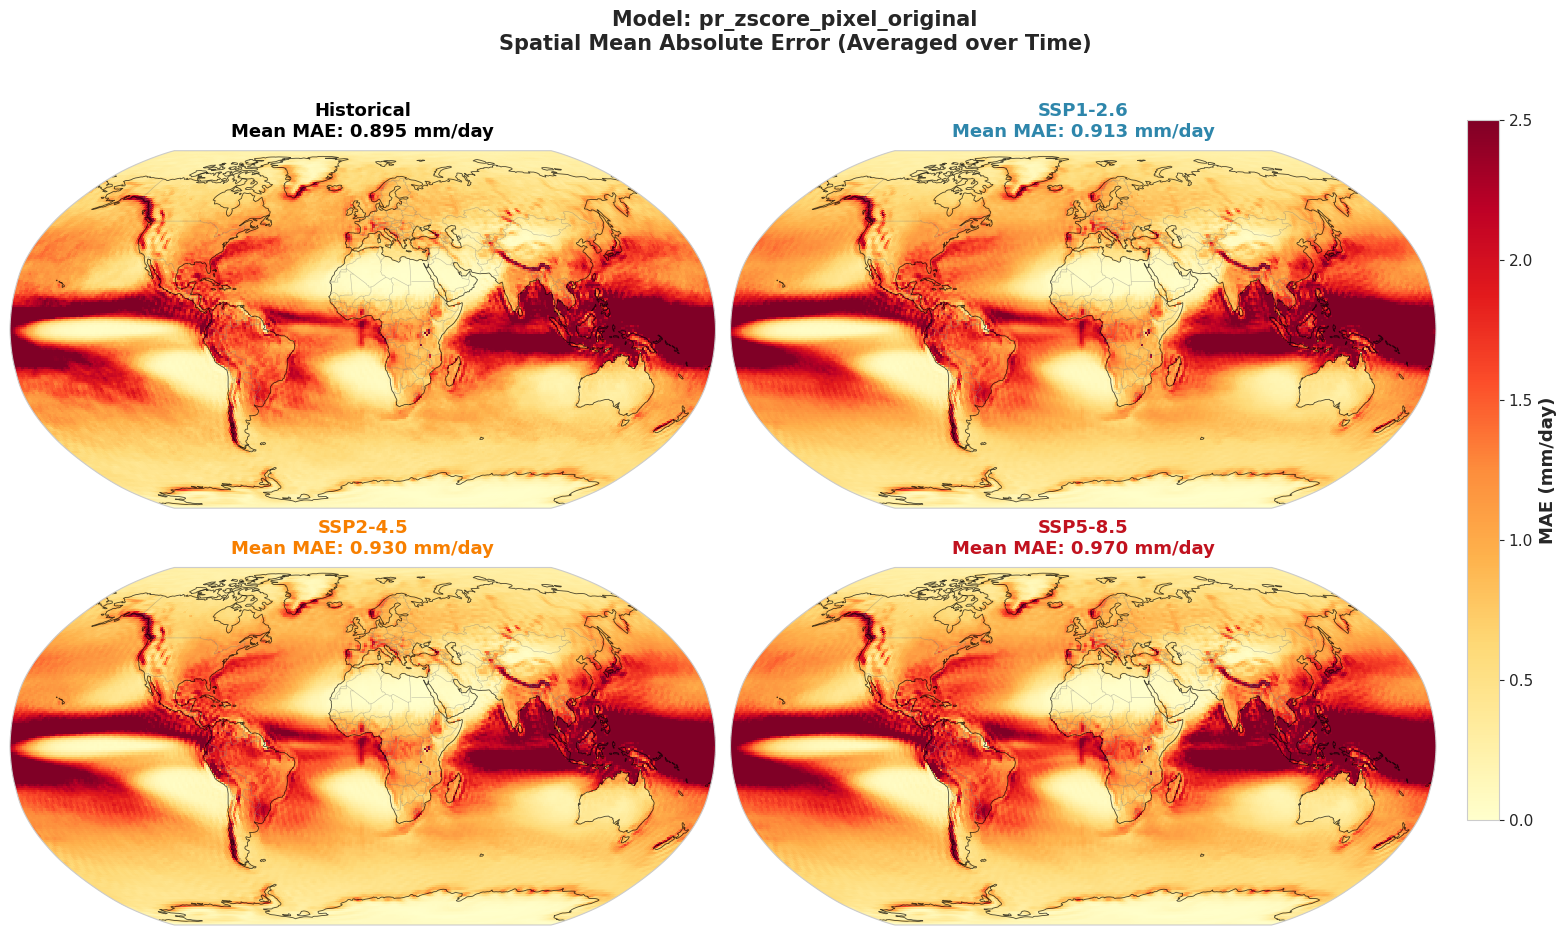

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']
model_name = 'pr_zscore_pixel_original'

# Load all scenario results
all_data = {}
for scenario in scenarios:
    filepath = eval_dir / f"pr_evaluation_{model_name}_{scenario}.nc"
    if filepath.exists():
        ds = xr.open_dataset(filepath)
        all_data[scenario] = ds
    else:
        print(f"Warning: File not found - {filepath}")

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Scenario colors
scenario_colors = {
    'historical': '#000000',
    'ssp126': '#2E86AB',
    'ssp245': '#F77F00',
    'ssp585': '#C1121F'
}

def calculate_spatial_mae(pred_data, gt_data):
    """Calculate MAE at each grid point (averaged over time)."""
    return np.mean(np.abs(pred_data - gt_data), axis=0)

# Determine global color scale
all_mae = []
for scenario in scenarios:
    if scenario not in all_data:
        continue
    ds = all_data[scenario]
    pred_data = ds['prediction'].values
    gt_data = ds['groundtruth'].values
    spatial_mae = calculate_spatial_mae(pred_data, gt_data)
    all_mae.append(spatial_mae)

all_mae = np.array(all_mae)
vmin = 0
vmax = np.percentile(all_mae, 95)

# Create figure: 2x2 grid for 4 scenarios
fig = plt.figure(figsize=(16, 10))

for idx, scenario in enumerate(scenarios):
    if scenario not in all_data:
        continue
    
    ds = all_data[scenario]
    pred_data = ds['prediction'].values
    gt_data = ds['groundtruth'].values
    lat = ds['lat'].values
    lon = ds['lon'].values
    
    # Calculate spatial MAE
    spatial_mae = calculate_spatial_mae(pred_data, gt_data)
    mean_mae = np.mean(spatial_mae)
    
    # Create subplot with map projection
    ax = fig.add_subplot(2, 2, idx + 1, projection=ccrs.Robinson())
    
    # Plot the data
    im = ax.pcolormesh(lon, lat, spatial_mae,
                      transform=ccrs.PlateCarree(),
                      cmap='YlOrRd', vmin=vmin, vmax=vmax,
                      shading='auto')
    
    # Add coastlines and features
    ax.coastlines(linewidth=0.6, color='black', alpha=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray', alpha=0.5)
    
    # Title with scenario name and mean MAE
    title = f'{scenario_labels[scenario]}\nMean MAE: {mean_mae:.3f} mm/day'
    ax.set_title(title, fontsize=13, fontweight='bold', pad=10, 
                color=scenario_colors[scenario])

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('MAE (mm/day)', fontsize=13, fontweight='bold')
cbar.ax.tick_params(labelsize=11)

# Overall title
fig.suptitle(f'Model: {model_name}\nSpatial Mean Absolute Error (Averaged over Time)', 
             fontsize=15, fontweight='bold', y=0.96)

plt.tight_layout(rect=[0, 0, 0.91, 0.94])

# # Save
# output_path = eval_dir / f'{model_name}_spatial_mae_maps.png'
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
# print(f"Figure saved to: {output_path}")

plt.show()


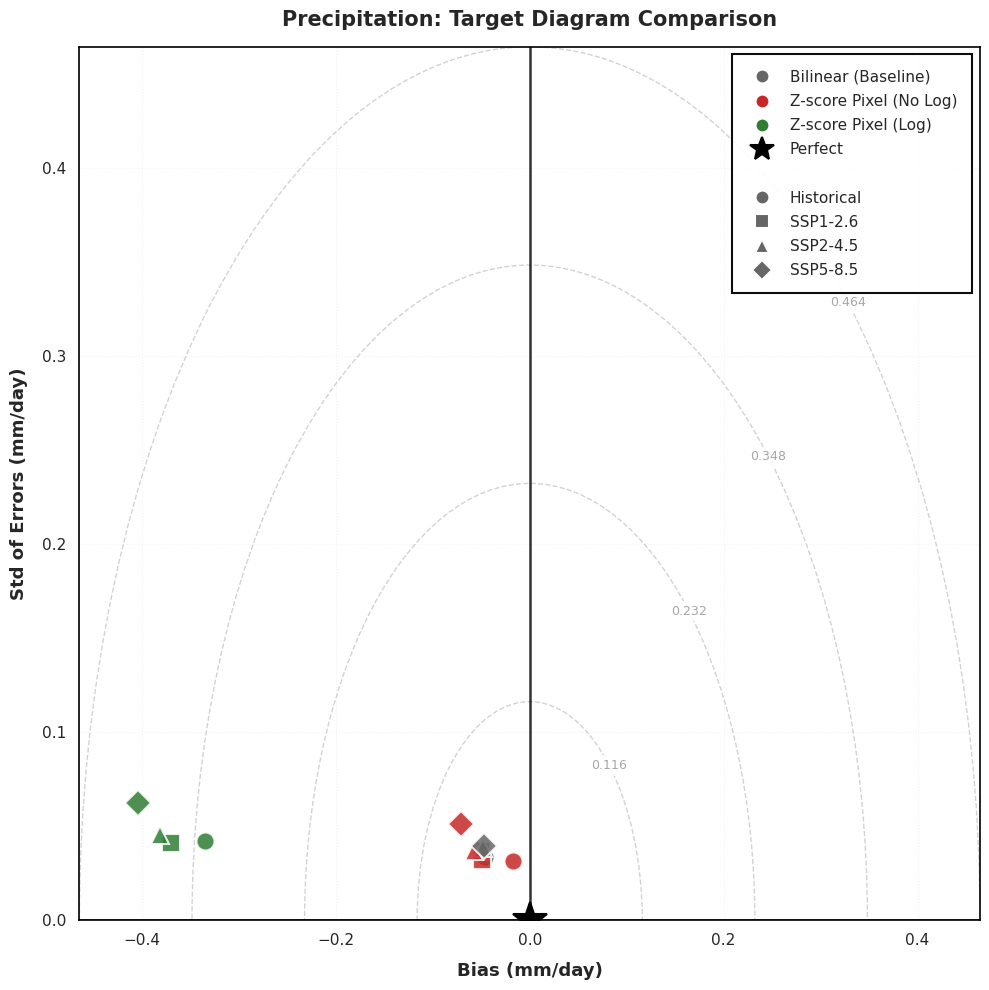

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
from matplotlib.patches import Circle
import matplotlib.lines as mlines

# Set style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.major.width'] = 1.2
plt.rcParams['ytick.major.width'] = 1.2

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Load data for different methods
all_data = {}

# Method 1: Pixel z-score with original (no log) data
model_name_original = 'pr_zscore_pixel_original'
all_data['original'] = {}
for scenario in scenarios:
    filepath = eval_dir / f"pr_evaluation_{model_name_original}_{scenario}.nc"
    if filepath.exists():
        all_data['original'][scenario] = xr.open_dataset(filepath)

# Method 2: Pixel z-score with log-transformed data
all_data['log'] = {}
for scenario in scenarios:
    filepath = eval_dir / f"pr_evaluation_{scenario}.nc"
    if filepath.exists():
        all_data['log'][scenario] = xr.open_dataset(filepath)

# Method configuration
methods = ['bilinear', 'original', 'log']

method_labels = {
    'bilinear': 'Bilinear (Baseline)',
    'original': 'Z-score Pixel (No Log)',
    'log': 'Z-score Pixel (Log)'
}

method_colors = {
    'bilinear': '#666666',  # Gray for baseline
    'original': '#C62828',  # Red
    'log': '#2E7D32'        # Green
}

# Marker styles for each scenario
scenario_markers = {
    'historical': 'o',  # circle
    'ssp126': 's',      # square
    'ssp245': '^',      # triangle up
    'ssp585': 'D'       # diamond
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

def calc_global_mean(data):
    """Calculate simple global mean time series"""
    if isinstance(data, xr.DataArray):
        return data.mean(dim=['lat', 'lon']).values
    else:
        return np.mean(data, axis=(1, 2))

def calculate_bias_std_stats_timeseries(pred_ts, gt_ts):
    """
    Calculate bias and standard deviation for target diagram using 1D time series.
    """
    # Remove NaN values
    mask = ~(np.isnan(pred_ts) | np.isnan(gt_ts))
    pred = pred_ts[mask]
    gt = gt_ts[mask]
    
    # Calculate errors
    errors = pred - gt
    
    # Bias (systematic error)
    bias = np.mean(errors)
    
    # Standard deviation of errors (random error component)
    std_error = np.std(errors)
    
    # Total RMSE
    rmse = np.sqrt(np.mean(errors**2))
    
    # Verify: RMSE² = Bias² + StdError²
    rmse_check = np.sqrt(bias**2 + std_error**2)
    assert np.isclose(rmse, rmse_check, rtol=1e-5), f"RMSE decomposition failed: {rmse} vs {rmse_check}"
    
    return bias, std_error, rmse

# Collect statistics for all scenarios and methods
all_stats = {}

for scenario in scenarios:
    all_stats[scenario] = {}
    
    # Get ground truth (same for all methods)
    if scenario in all_data['original']:
        gt_data = all_data['original'][scenario]['groundtruth']
        gt_mean = calc_global_mean(gt_data)
        
        # Method 1: Bilinear baseline (input as prediction)
        input_data = all_data['original'][scenario]['input']
        input_mean = calc_global_mean(input_data)
        bias, std_error, rmse = calculate_bias_std_stats_timeseries(input_mean, gt_mean)
        all_stats[scenario]['bilinear'] = {
            'bias': bias,
            'std_error': std_error,
            'rmse': rmse
        }
        
        # Method 2: Original (no log)
        pred_data = all_data['original'][scenario]['prediction']
        pred_mean = calc_global_mean(pred_data)
        bias, std_error, rmse = calculate_bias_std_stats_timeseries(pred_mean, gt_mean)
        all_stats[scenario]['original'] = {
            'bias': bias,
            'std_error': std_error,
            'rmse': rmse
        }
    
    # Method 3: Log-transformed
    if scenario in all_data['log']:
        # Get ground truth from log data
        gt_data_log = all_data['log'][scenario]['groundtruth']
        gt_mean_log = calc_global_mean(gt_data_log)
        
        # Pixel z-score with log
        pred_data_log = all_data['log'][scenario]['pred_zscore_pixel']
        pred_mean_log = calc_global_mean(pred_data_log)
        bias, std_error, rmse = calculate_bias_std_stats_timeseries(pred_mean_log, gt_mean_log)
        all_stats[scenario]['log'] = {
            'bias': bias,
            'std_error': std_error,
            'rmse': rmse
        }

# Create single plot figure
fig, ax = plt.subplots(figsize=(10, 10))

# Find max values for axis limits
max_bias = 0
max_std = 0

for scenario in scenarios:
    for method in methods:
        if method in all_stats[scenario]:
            stats = all_stats[scenario][method]
            max_bias = max(max_bias, abs(stats['bias']))
            max_std = max(max_std, stats['std_error'])

# Add padding
axis_limit = max(max_bias, max_std) * 1.15

# Draw RMSE circles
rmse_levels = np.linspace(0, axis_limit, 5)[1:]  # 4 circles

for rmse_level in rmse_levels:
    circle = Circle((0, 0), rmse_level, fill=False, 
                    edgecolor='gray', linestyle='--',
                    linewidth=1.0, alpha=0.35)
    ax.add_patch(circle)
    
    ax.text(rmse_level * 0.707, rmse_level * 0.707,
            f'{rmse_level:.3f}',
            fontsize=9, color='gray', alpha=0.7,
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                      edgecolor='none', alpha=0.85))

# Draw axes
ax.axhline(y=0, color='black', linewidth=1.8, alpha=0.8, zorder=2)
ax.axvline(x=0, color='black', linewidth=1.8, alpha=0.8, zorder=2)

# Draw grid
ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.8, zorder=1)

# Plot reference point (perfect model at origin)
ax.plot(0, 0, 'k*', markersize=26, 
       markeredgecolor='black', markeredgewidth=1.5, zorder=100)

# Plot all model points
for scenario in scenarios:
    for method in methods:
        if method in all_stats[scenario]:
            stats = all_stats[scenario][method]
            
            bias = stats['bias']
            std_error = stats['std_error']
            
            ax.plot(bias, std_error,
                   marker=scenario_markers[scenario],
                   color=method_colors[method],
                   markersize=13,
                   markeredgecolor='white',
                   markeredgewidth=1.5,
                   alpha=0.85,
                   linestyle='none',
                   zorder=50)

# Set equal aspect ratio and limits
ax.set_xlim(-axis_limit, axis_limit)
ax.set_ylim(0, axis_limit)

# Labels
ax.set_xlabel('Bias (mm/day)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('Std of Errors (mm/day)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Precipitation: Target Diagram Comparison', fontsize=15, fontweight='bold', pad=15)

# Improve tick formatting
ax.tick_params(labelsize=11, length=6, width=1.2)

# Make spines more visible
for spine in ax.spines.values():
    spine.set_linewidth(1.2)
    spine.set_edgecolor('black')

# Create legend
all_handles = []
all_labels = []

# Add methods
for method in methods:
    handle = mlines.Line2D([], [], color=method_colors[method], 
                          marker='o', linestyle='None',
                          markersize=10,
                          markeredgecolor='white', markeredgewidth=1.5)
    all_handles.append(handle)
    all_labels.append(method_labels[method])

# Add reference point
ref_handle = mlines.Line2D([], [], color='black', marker='*', 
                          linestyle='None', markersize=18,
                          markeredgecolor='black', markeredgewidth=1.5)
all_handles.append(ref_handle)
all_labels.append('Perfect')

# Add spacing
all_handles.append(mlines.Line2D([], [], linestyle='None', marker='', markersize=0))
all_labels.append('')

# Add scenarios
for scenario in scenarios:
    handle = mlines.Line2D([], [], color='#666666', 
                          marker=scenario_markers[scenario], 
                          linestyle='None',
                          markersize=10,
                          markeredgecolor='white', markeredgewidth=1.5)
    all_handles.append(handle)
    all_labels.append(scenario_labels[scenario])

# Position legend
legend = ax.legend(handles=all_handles, labels=all_labels,
                  loc='upper right', fontsize=11, frameon=True,
                  fancybox=False, edgecolor='black', framealpha=0.95,
                  borderpad=1.0, labelspacing=0.6)
legend.get_frame().set_linewidth(1.5)

plt.tight_layout()

# # Save
# output_path = eval_dir / 'pr_target_diagram_comparison.png'
# plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
# print(f"Figure saved to: {output_path}")

plt.show()


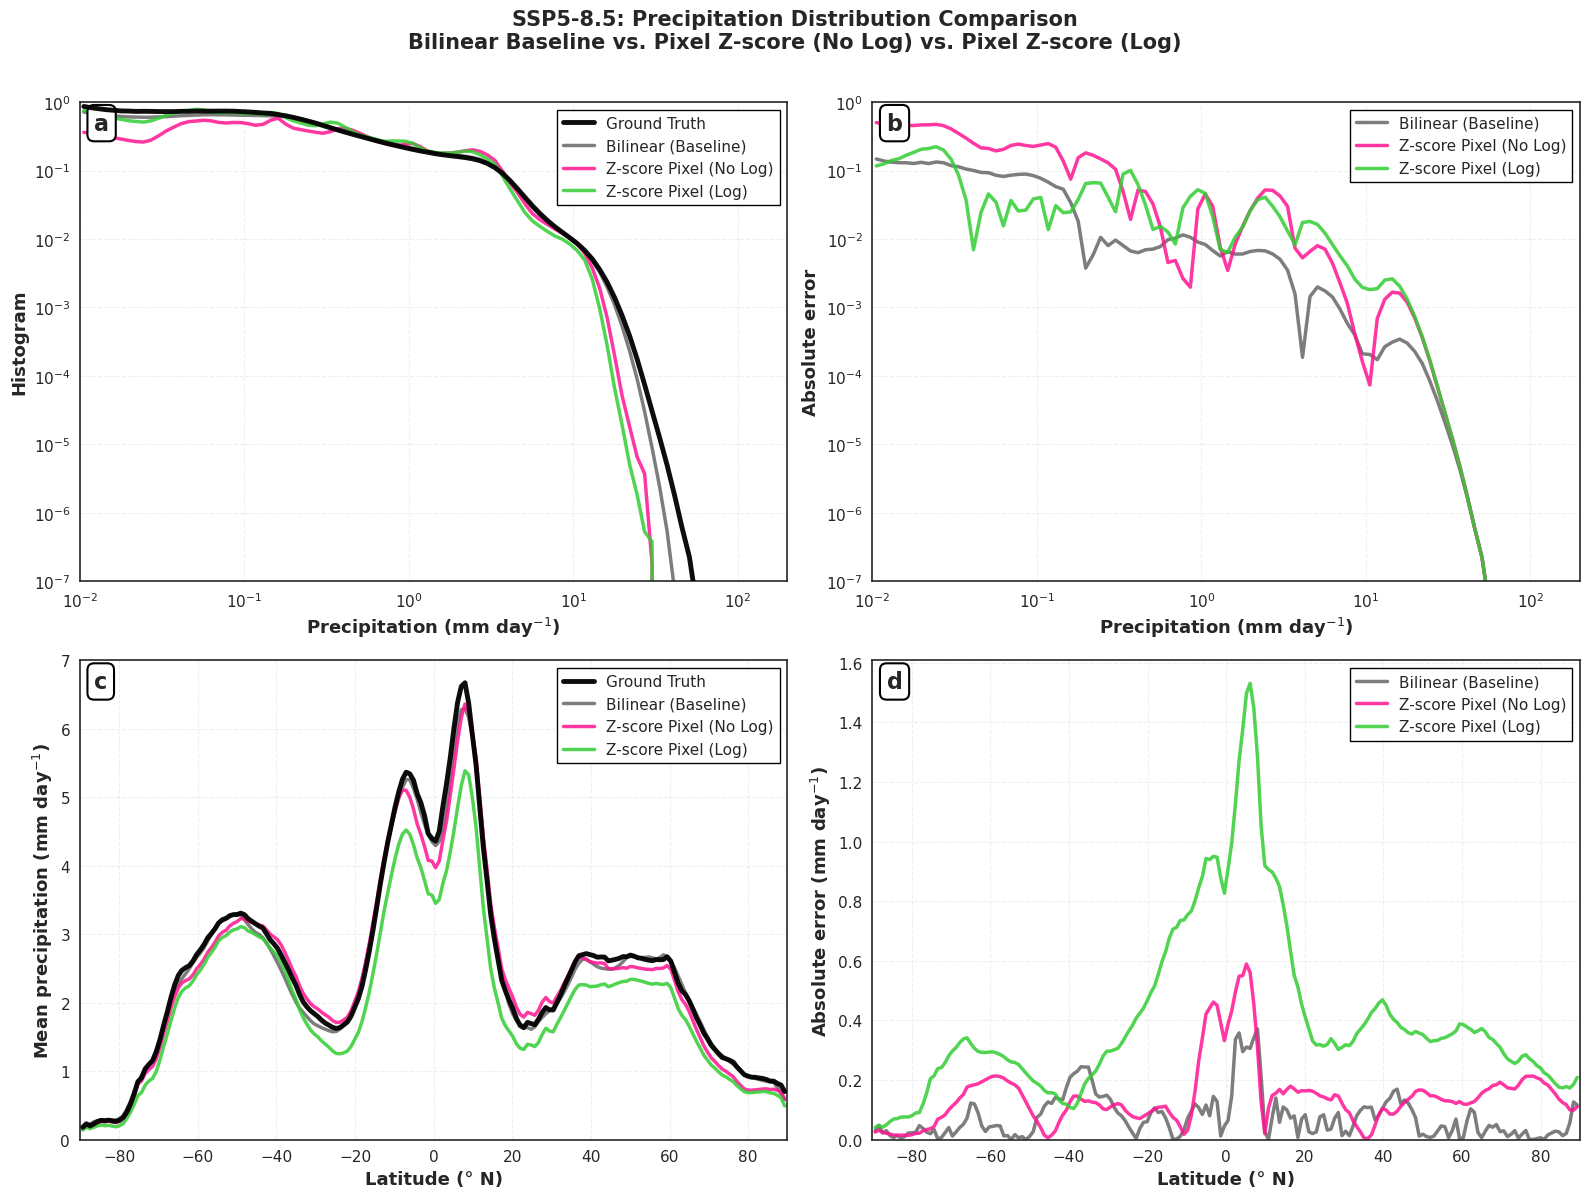

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns

# Set style
sns.set_style("white")

# Load evaluation results for SSP585 only
eval_dir = Path("evaluation_results")

# Load data for different methods
model_name_original = 'pr_zscore_pixel_original'

# Load original (no log) data
ds_original = xr.open_dataset(eval_dir / f"pr_evaluation_{model_name_original}_ssp585.nc")

# Load log-transformed data
ds_log = xr.open_dataset(eval_dir / "pr_evaluation_ssp585.nc")

# Method configuration
methods = ['bilinear', 'original', 'log']

method_labels = {
    'bilinear': 'Bilinear (Baseline)',
    'original': 'Z-score Pixel (No Log)',
    'log': 'Z-score Pixel (Log)'
}

method_colors = {
    'bilinear': '#666666',  # Gray
    'original': '#FF1493',  # Magenta
    'log': '#32CD32'        # Lime green
}

# Ground truth color
gt_color = '#000000'  # Black

# Get coordinates
lat = ds_original['lat'].values
lon = ds_original['lon'].values

# Get ground truth data (from original, not log-transformed)
gt_data = ds_original['groundtruth'].values

# Get prediction data for all methods
pred_data = {}
pred_data['bilinear'] = ds_original['input'].values  # Baseline is the input
pred_data['original'] = ds_original['prediction'].values
pred_data['log'] = ds_log['pred_zscore_pixel'].values  # Log-transformed prediction

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# ---------------------------
# Panel (a): Global Histogram
# ---------------------------
ax = axes[0]

# Calculate histogram for ground truth
bins = np.logspace(-2, 2.5, 100)  # Log-spaced bins from 0.01 to ~300 mm/day
gt_hist, bin_edges = np.histogram(gt_data.flatten(), bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot ground truth
ax.plot(bin_centers, gt_hist, color=gt_color, linewidth=3.5, 
        label='Ground Truth', alpha=0.95, zorder=20)

# Plot predictions
for method in methods:
    if method in pred_data:
        pred_hist, _ = np.histogram(pred_data[method].flatten(), bins=bins, density=True)
        ax.plot(bin_centers, pred_hist, 
               color=method_colors[method],
               linewidth=2.5, alpha=0.85,
               label=method_labels[method])

ax.set_xlabel('Precipitation (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_ylabel('Histogram', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 200)
ax.set_ylim(1e-7, 1)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=11, framealpha=0.98, edgecolor='black', 
          fancybox=False, frameon=True)
ax.text(0.02, 0.98, 'a', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# ---------------------------
# Panel (b): Absolute Error of Histogram
# ---------------------------
ax = axes[1]

# Calculate absolute errors
for method in methods:
    if method in pred_data:
        pred_hist, _ = np.histogram(pred_data[method].flatten(), bins=bins, density=True)
        abs_error = np.abs(pred_hist - gt_hist)
        ax.plot(bin_centers, abs_error, 
               color=method_colors[method],
               linewidth=2.5, alpha=0.85,
               label=method_labels[method])

ax.set_xlabel('Precipitation (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_ylabel('Absolute error', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 200)
ax.set_ylim(1e-7, 1)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=11, framealpha=0.98, edgecolor='black',
          fancybox=False, frameon=True)
ax.text(0.02, 0.98, 'b', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# ---------------------------
# Panel (c): Latitudinal Mean Precipitation
# ---------------------------
ax = axes[2]

# Calculate latitudinal means
gt_lat_mean = np.mean(gt_data, axis=(0, 2))  # Average over time and longitude

# Plot ground truth
ax.plot(lat, gt_lat_mean, color=gt_color, linewidth=3.5,
        label='Ground Truth', alpha=0.95, zorder=20)

# Plot predictions
for method in methods:
    if method in pred_data:
        pred_lat_mean = np.mean(pred_data[method], axis=(0, 2))
        ax.plot(lat, pred_lat_mean,
               color=method_colors[method],
               linewidth=2.5, alpha=0.85,
               label=method_labels[method])

ax.set_xlabel('Latitude (° N)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean precipitation (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_xlim(-90, 90)
ax.set_ylim(0, None)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=11, framealpha=0.98, edgecolor='black',
          fancybox=False, frameon=True)
ax.text(0.02, 0.98, 'c', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# ---------------------------
# Panel (d): Absolute Error of Latitudinal Mean
# ---------------------------
ax = axes[3]

# Calculate absolute errors
for method in methods:
    if method in pred_data:
        pred_lat_mean = np.mean(pred_data[method], axis=(0, 2))
        abs_error = np.abs(pred_lat_mean - gt_lat_mean)
        ax.plot(lat, abs_error,
               color=method_colors[method],
               linewidth=2.5, alpha=0.85,
               label=method_labels[method])

ax.set_xlabel('Latitude (° N)', fontsize=13, fontweight='bold')
ax.set_ylabel('Absolute error (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_xlim(-90, 90)
ax.set_ylim(0, None)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=11, framealpha=0.98, edgecolor='black',
          fancybox=False, frameon=True)
ax.text(0.02, 0.98, 'd', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Overall title
fig.suptitle('SSP5-8.5: Precipitation Distribution Comparison\n' + 
             'Bilinear Baseline vs. Pixel Z-score (No Log) vs. Pixel Z-score (Log)',
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.985])

# # Save
# output_path = eval_dir / 'pr_ssp585_distribution_comparison.png'
# plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
# print(f"Figure saved to: {output_path}")

plt.show()


/tmp/ipykernel_151237/3375067035.py:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 0.94])


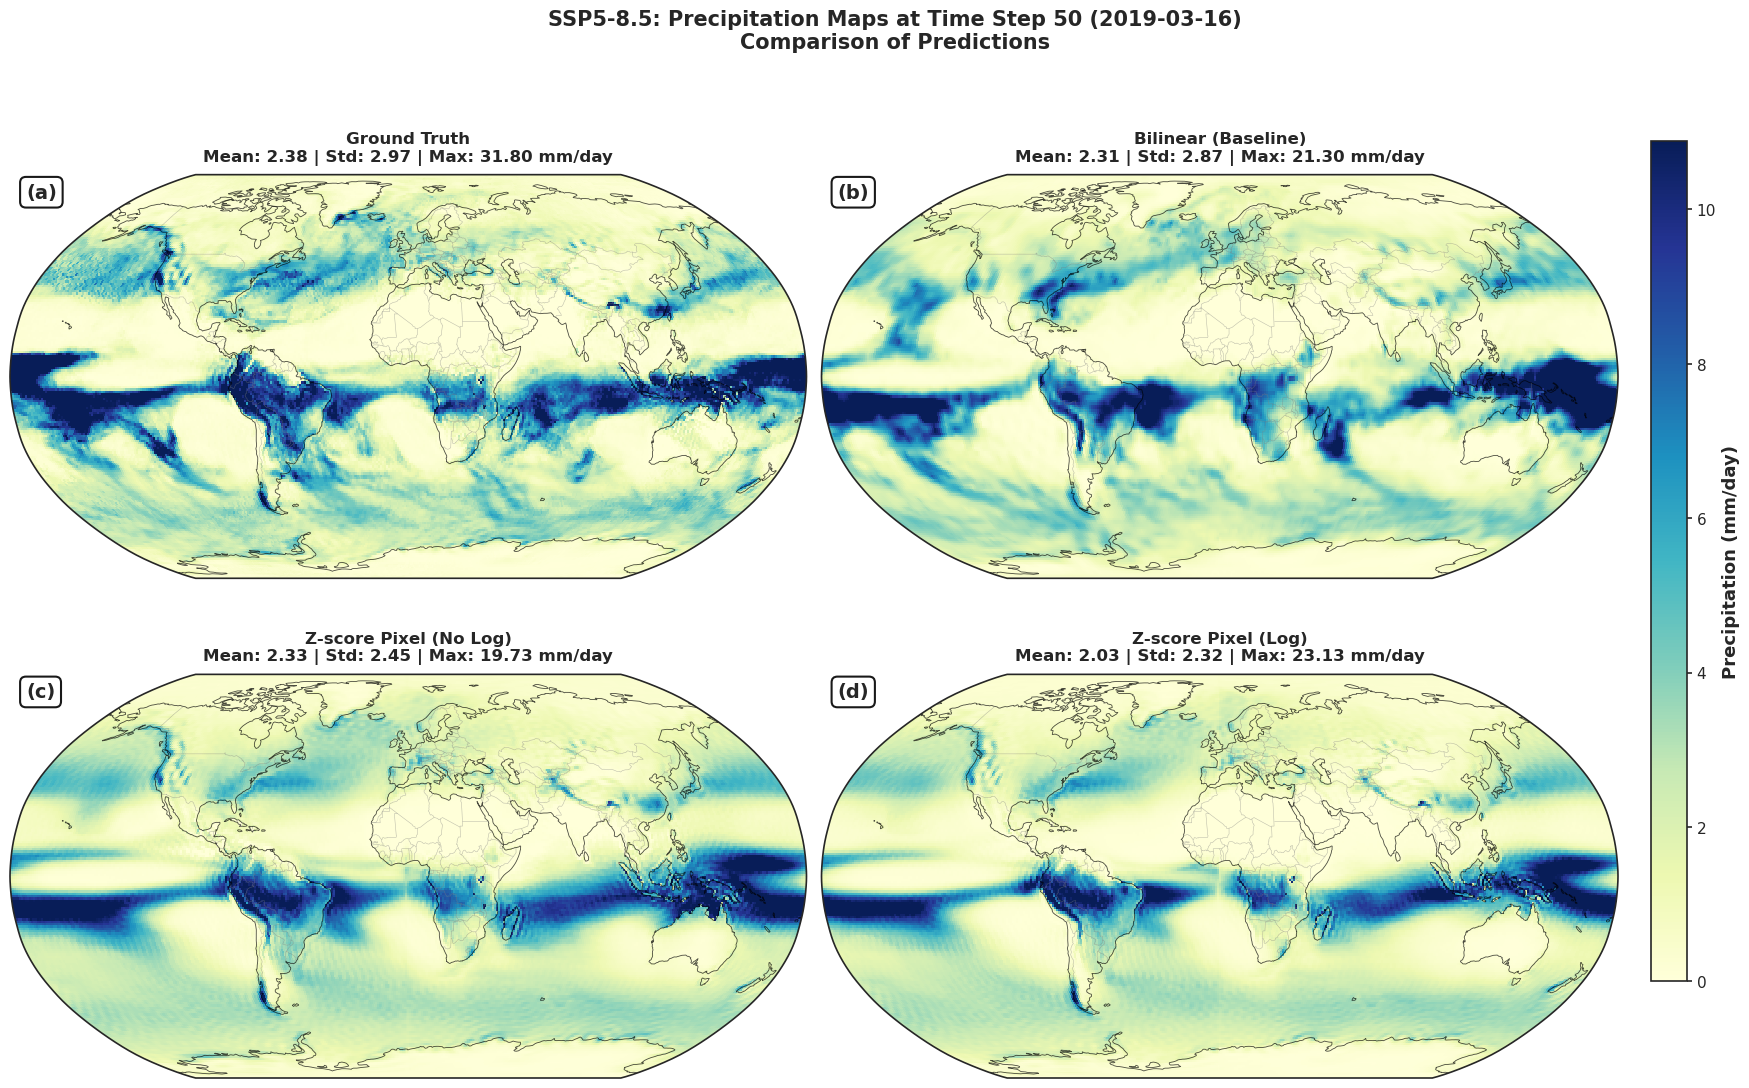

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load evaluation results for SSP585
eval_dir = Path("evaluation_results")
model_name_original = 'pr_zscore_pixel_original'

# Load data
ds_original = xr.open_dataset(eval_dir / f"pr_evaluation_{model_name_original}_ssp585.nc")
ds_log = xr.open_dataset(eval_dir / "pr_evaluation_ssp585.nc")

# Select time index
time_idx = 50

# Method configuration
method_labels = {
    'groundtruth': 'Ground Truth',
    'bilinear': 'Bilinear (Baseline)',
    'original': 'Z-score Pixel (No Log)',
    'log': 'Z-score Pixel (Log)'
}

# Get coordinates
lat = ds_original['lat'].values
lon = ds_original['lon'].values
time_value = ds_original['time'].values[time_idx]

# Extract data for selected time step
data_maps = {}
data_maps['groundtruth'] = ds_original['groundtruth'].isel(time=time_idx).values
data_maps['bilinear'] = ds_original['input'].isel(time=time_idx).values
data_maps['original'] = ds_original['prediction'].isel(time=time_idx).values
data_maps['log'] = ds_log['pred_zscore_pixel'].isel(time=time_idx).values

# Create figure with 2x2 subplots
fig = plt.figure(figsize=(18, 12))

# Determine color scale (use percentiles to avoid outliers)
all_data = np.concatenate([data_maps[k].flatten() for k in data_maps.keys()])
vmin = 0
vmax = np.percentile(all_data, 98)

# Plot each method
plot_order = ['groundtruth', 'bilinear', 'original', 'log']
titles = [method_labels[k] for k in plot_order]

for idx, method in enumerate(plot_order):
    ax = fig.add_subplot(2, 2, idx + 1, projection=ccrs.Robinson())
    
    # Plot the data
    im = ax.pcolormesh(lon, lat, data_maps[method],
                      transform=ccrs.PlateCarree(),
                      cmap='YlGnBu', vmin=vmin, vmax=vmax,
                      shading='auto')
    
    # Add coastlines and features
    ax.coastlines(linewidth=0.6, color='black', alpha=0.7)
    ax.add_feature(cfeature.BORDERS, linewidth=0.4, edgecolor='gray', alpha=0.5)
    
    # Calculate statistics for this map
    mean_val = np.mean(data_maps[method])
    std_val = np.std(data_maps[method])
    max_val = np.max(data_maps[method])
    
    # Title with statistics
    title = f'{titles[idx]}\nMean: {mean_val:.2f} | Std: {std_val:.2f} | Max: {max_val:.2f} mm/day'
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    
    # Add panel label
    panel_labels = ['(a)', '(b)', '(c)', '(d)']
    ax.text(0.02, 0.98, panel_labels[idx], transform=ax.transAxes,
           fontsize=14, fontweight='bold', va='top', ha='left',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='black', linewidth=1.5, alpha=0.9))

# Add a single colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Precipitation (mm/day)', fontsize=13, fontweight='bold')
cbar.ax.tick_params(labelsize=11)

# Overall title with time information
time_str = np.datetime_as_string(time_value, unit='D')
fig.suptitle(f'SSP5-8.5: Precipitation Maps at Time Step {time_idx} ({time_str})\n' + 
             'Comparison of Predictions',
             fontsize=15, fontweight='bold', y=0.96)

plt.tight_layout(rect=[0, 0, 0.91, 0.94])

# # Save
# output_path = eval_dir / f'pr_ssp585_2d_maps_t{time_idx}.png'
# plt.savefig(output_path, dpi=300, bbox_inches='tight')
# print(f"Figure saved to: {output_path}")

plt.show()


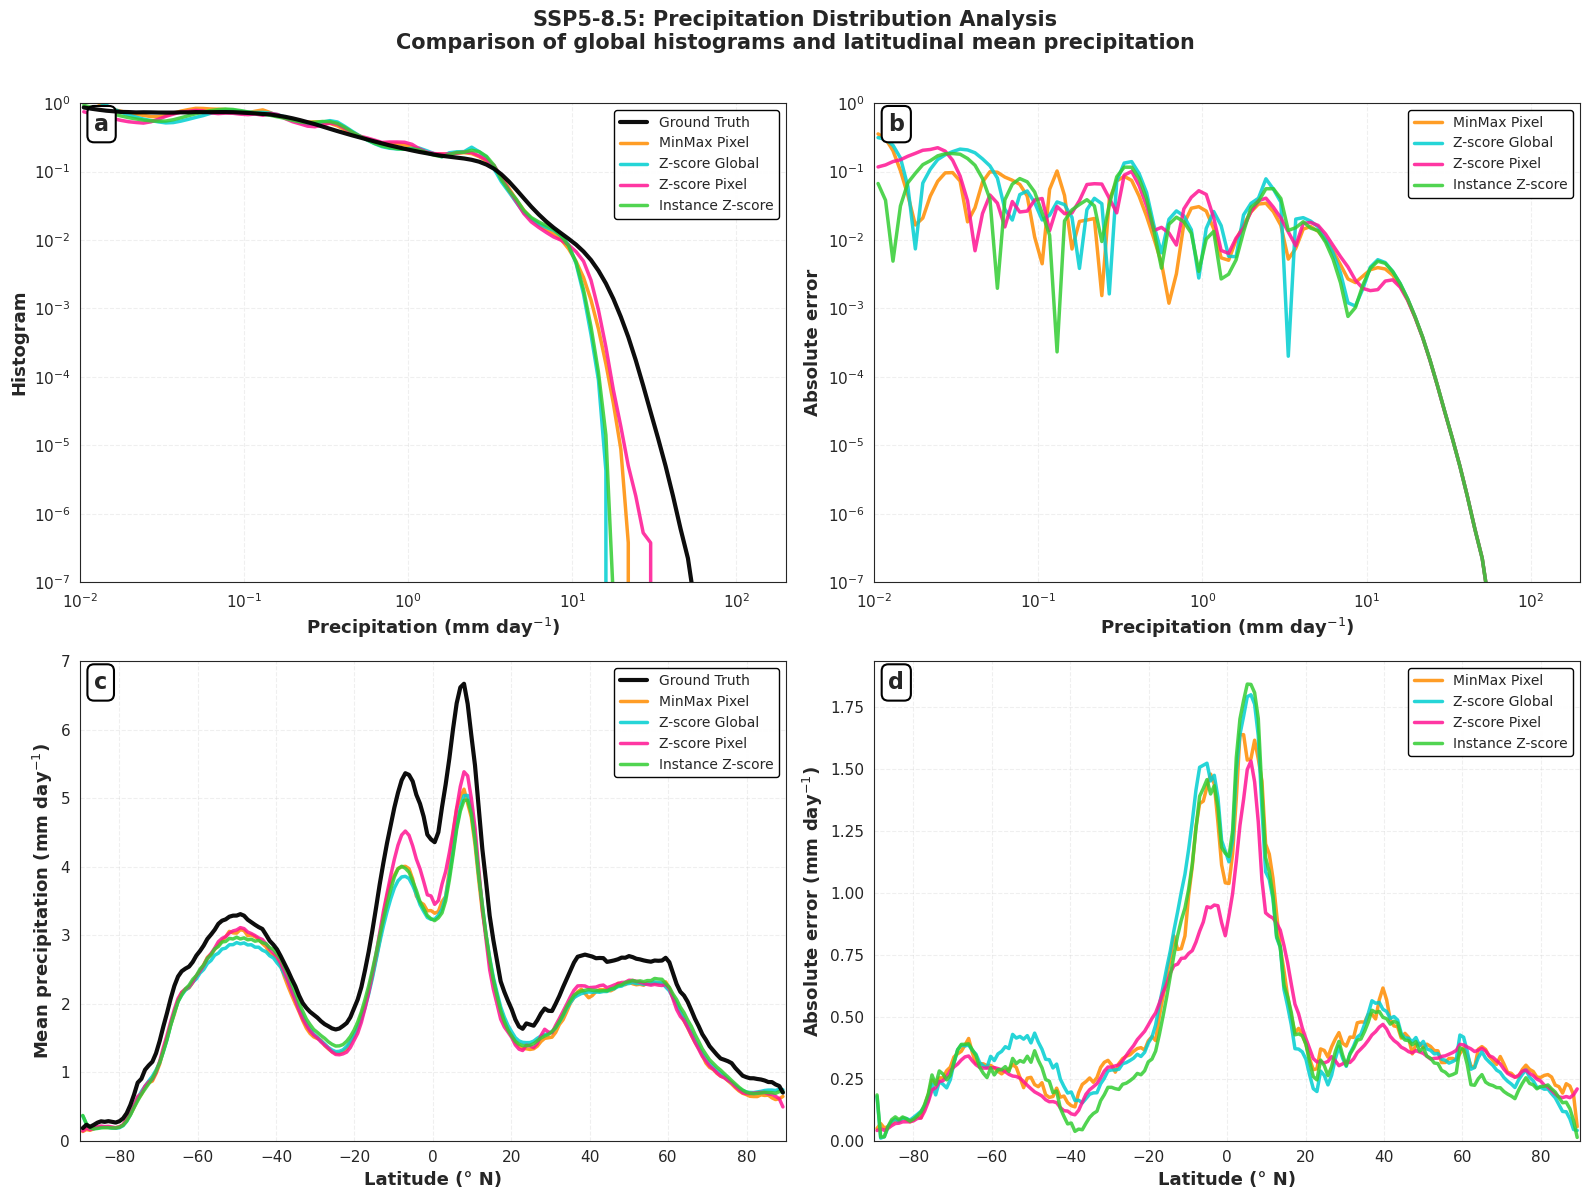

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns

# Set style
sns.set_style("white")

# Load evaluation results for SSP585 only
eval_dir = Path("evaluation_results")
ds = xr.open_dataset(eval_dir / "pr_evaluation_ssp585.nc")

# Selected normalization methods
norm_methods = ['minmax_pixel', 'zscore_global', 'zscore_pixel', 'instance_zscore']

# Model labels for display
model_labels = {
    'minmax_pixel': 'MinMax Pixel',
    'zscore_global': 'Z-score Global',
    'zscore_pixel': 'Z-score Pixel',
    'instance_zscore': 'Instance Z-score'
}

# Colors for each model
model_colors = {
    'minmax_pixel': '#FF8C00',    # Orange
    'zscore_global': '#00CED1',   # Cyan
    'zscore_pixel': '#FF1493',    # Magenta
    'instance_zscore': '#32CD32'  # Lime green
}

# Ground truth color
gt_color = '#000000'  # Black

# Get ground truth data
gt_data = ds['groundtruth'].values
lat = ds['lat'].values
lon = ds['lon'].values

# Get prediction data for all methods
pred_data = {}
for norm_method in norm_methods:
    pred_key = f'pred_{norm_method}'
    if pred_key in ds:
        pred_data[norm_method] = ds[pred_key].values

# Create 2x2 subplot figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# ---------------------------
# Panel (a): Global Histogram
# ---------------------------
ax = axes[0]

# Calculate histogram for ground truth
bins = np.logspace(-2, 2.5, 100)  # Log-spaced bins from 0.01 to ~300 mm/day
gt_hist, bin_edges = np.histogram(gt_data.flatten(), bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot ground truth
ax.plot(bin_centers, gt_hist, color=gt_color, linewidth=3, 
        label='Ground Truth', alpha=0.95, zorder=20)

# Plot predictions
for norm_method in norm_methods:
    if norm_method in pred_data:
        pred_hist, _ = np.histogram(pred_data[norm_method].flatten(), bins=bins, density=True)
        ax.plot(bin_centers, pred_hist, 
               color=model_colors[norm_method],
               linewidth=2.5, alpha=0.85,
               label=model_labels[norm_method])

ax.set_xlabel('Precipitation (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_ylabel('Histogram', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 200)
ax.set_ylim(1e-7, 1)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=10, framealpha=0.98, edgecolor='black')
ax.text(0.02, 0.98, 'a', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# ---------------------------
# Panel (b): Absolute Error of Histogram
# ---------------------------
ax = axes[1]

# Calculate absolute errors
for norm_method in norm_methods:
    if norm_method in pred_data:
        pred_hist, _ = np.histogram(pred_data[norm_method].flatten(), bins=bins, density=True)
        abs_error = np.abs(pred_hist - gt_hist)
        ax.plot(bin_centers, abs_error, 
               color=model_colors[norm_method],
               linewidth=2.5, alpha=0.85,
               label=model_labels[norm_method])

ax.set_xlabel('Precipitation (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_ylabel('Absolute error', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.01, 200)
ax.set_ylim(1e-7, 1)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=10, framealpha=0.98, edgecolor='black')
ax.text(0.02, 0.98, 'b', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# ---------------------------
# Panel (c): Latitudinal Mean Precipitation
# ---------------------------
ax = axes[2]

# Calculate latitudinal means
gt_lat_mean = np.mean(gt_data, axis=(0, 2))  # Average over time and longitude

# Plot ground truth
ax.plot(lat, gt_lat_mean, color=gt_color, linewidth=3,
        label='Ground Truth', alpha=0.95, zorder=20)

# Plot predictions
for norm_method in norm_methods:
    if norm_method in pred_data:
        pred_lat_mean = np.mean(pred_data[norm_method], axis=(0, 2))
        ax.plot(lat, pred_lat_mean,
               color=model_colors[norm_method],
               linewidth=2.5, alpha=0.85,
               label=model_labels[norm_method])

ax.set_xlabel('Latitude (° N)', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean precipitation (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_xlim(-90, 90)
ax.set_ylim(0, None)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=10, framealpha=0.98, edgecolor='black')
ax.text(0.02, 0.98, 'c', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# ---------------------------
# Panel (d): Absolute Error of Latitudinal Mean
# ---------------------------
ax = axes[3]

# Calculate absolute errors
for norm_method in norm_methods:
    if norm_method in pred_data:
        pred_lat_mean = np.mean(pred_data[norm_method], axis=(0, 2))
        abs_error = np.abs(pred_lat_mean - gt_lat_mean)
        ax.plot(lat, abs_error,
               color=model_colors[norm_method],
               linewidth=2.5, alpha=0.85,
               label=model_labels[norm_method])

ax.set_xlabel('Latitude (° N)', fontsize=13, fontweight='bold')
ax.set_ylabel('Absolute error (mm day$^{-1}$)', fontsize=13, fontweight='bold')
ax.set_xlim(-90, 90)
ax.set_ylim(0, None)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='upper right', fontsize=10, framealpha=0.98, edgecolor='black')
ax.text(0.02, 0.98, 'd', transform=ax.transAxes,
       fontsize=16, fontweight='bold', va='top', ha='left',
       bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                edgecolor='black', linewidth=1.5))
ax.tick_params(labelsize=11)
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)

# Overall title
fig.suptitle('SSP5-8.5: Precipitation Distribution Analysis\n' + 
             'Comparison of global histograms and latitudinal mean precipitation',
             fontsize=15, fontweight='bold', y=0.995)

plt.tight_layout(rect=[0, 0, 1, 0.985])

# # Save
# plt.savefig('pr_ssp585_distribution_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
# plt.savefig('pr_ssp585_distribution_analysis.pdf', bbox_inches='tight', facecolor='white')

plt.show()


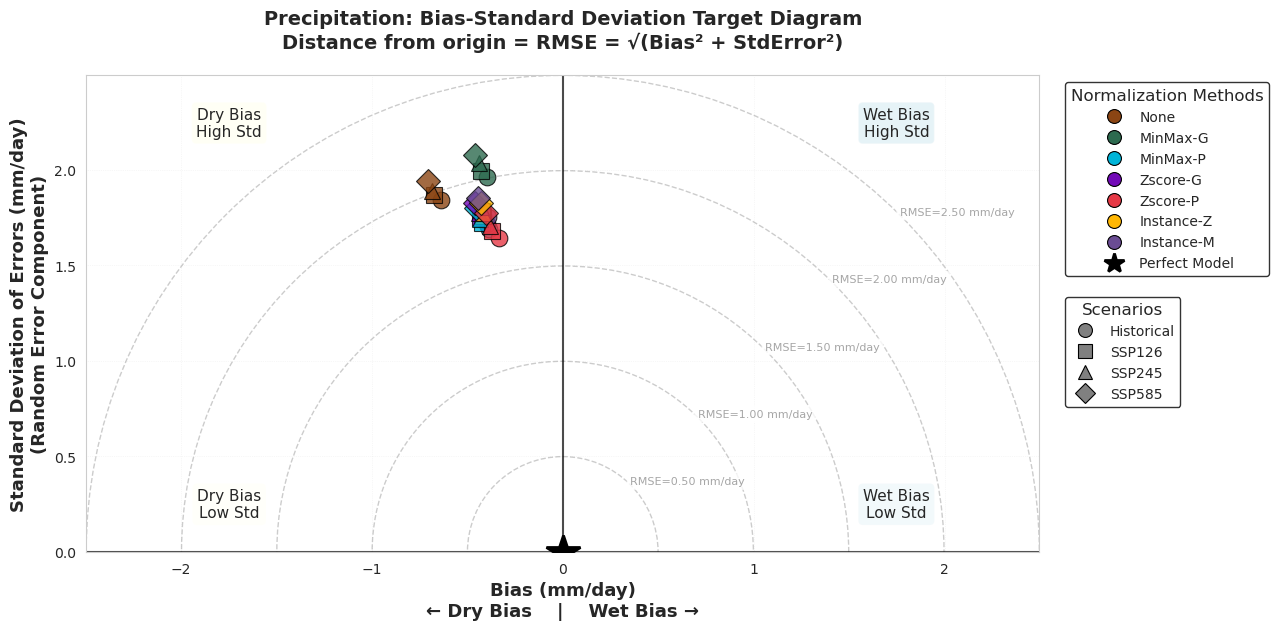

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns
import matplotlib.lines as mlines
from matplotlib.patches import Circle

# Set style
sns.set_style("whitegrid")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# Load all scenario results
all_data = {}
for scenario in scenarios:
    ds = xr.open_dataset(eval_dir / f"pr_evaluation_{scenario}.nc")
    all_data[scenario] = ds

# Normalization methods
norm_methods = ['none', 'minmax_global', 'minmax_pixel', 'zscore_global', 
                'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Model labels for display
model_labels = {
    'none': 'None',
    'minmax_global': 'MinMax-G',
    'minmax_pixel': 'MinMax-P',
    'zscore_global': 'Zscore-G',
    'zscore_pixel': 'Zscore-P',
    'instance_zscore': 'Instance-Z',
    'instance_minmax': 'Instance-M'
}

# Colors for each normalization method
model_colors = {
    'none': '#8B4513',
    'minmax_global': '#2D6A4F',
    'minmax_pixel': '#00B4D8',
    'zscore_global': '#7209B7',
    'zscore_pixel': '#E63946',
    'instance_zscore': '#FFB703',
    'instance_minmax': '#6A4C93'
}

# Marker styles for each scenario
scenario_markers = {
    'historical': 'o',  # circle
    'ssp126': 's',      # square
    'ssp245': '^',      # triangle up
    'ssp585': 'D'       # diamond
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP126',
    'ssp245': 'SSP245',
    'ssp585': 'SSP585'
}

def calculate_bias_std_stats(pred_data, gt_data):
    """
    Calculate bias and standard deviation for target diagram.
    
    Returns:
    - bias: mean bias (prediction - ground truth) in mm/day
    - std_error: standard deviation of errors in mm/day (random error component)
    - rmse: total RMSE in mm/day
    - mae: mean absolute error in mm/day
    
    Note: RMSE² = Bias² + StdError²
    """
    # Flatten all data
    pred_flat = pred_data.flatten()
    gt_flat = gt_data.flatten()
    
    # Remove NaN values
    mask = ~(np.isnan(pred_flat) | np.isnan(gt_flat))
    pred_flat = pred_flat[mask]
    gt_flat = gt_flat[mask]
    
    # Calculate errors
    errors = pred_flat - gt_flat
    
    # Bias (systematic error)
    bias = np.mean(errors)
    
    # Standard deviation of errors (random error component)
    std_error = np.std(errors)
    
    # Total RMSE
    rmse = np.sqrt(np.mean(errors**2))
    
    # MAE
    mae = np.mean(np.abs(errors))
    
    # Verify: RMSE² = Bias² + StdError²
    rmse_check = np.sqrt(bias**2 + std_error**2)
    assert np.isclose(rmse, rmse_check, rtol=1e-5), f"RMSE decomposition failed: {rmse} vs {rmse_check}"
    
    return bias, std_error, rmse, mae

# Collect statistics for all scenarios and methods
bias_std_stats = {}

for scenario in scenarios:
    ds = all_data[scenario]
    gt_data = ds['groundtruth'].values
    
    bias_std_stats[scenario] = {}
    
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            
            bias, std_error, rmse, mae = calculate_bias_std_stats(pred_data, gt_data)
            
            bias_std_stats[scenario][norm_method] = {
                'bias': bias,
                'std_error': std_error,
                'rmse': rmse,
                'mae': mae
            }

# Create Target Diagram (Bias-StdError plot)
fig, ax = plt.subplots(figsize=(12, 12))

# Find max values for axis limits
max_bias = 0
max_std = 0
max_rmse = 0

for scenario in scenarios:
    for norm_method in norm_methods:
        if norm_method in bias_std_stats[scenario]:
            stats = bias_std_stats[scenario][norm_method]
            max_bias = max(max_bias, abs(stats['bias']))
            max_std = max(max_std, stats['std_error'])
            max_rmse = max(max_rmse, stats['rmse'])

# Add padding
axis_limit = max(max_bias, max_std) * 1.2

# Draw RMSE circles (distance from origin)
rmse_levels = np.linspace(0, axis_limit, 6)[1:]  # Skip 0
for rmse_level in rmse_levels:
    circle = Circle((0, 0), rmse_level, fill=False, 
                   edgecolor='gray', linestyle='--', 
                   linewidth=1, alpha=0.4, zorder=1)
    ax.add_patch(circle)
    # Label
    ax.text(rmse_level * 0.707, rmse_level * 0.707, 
           f'RMSE={rmse_level:.2f} mm/day', 
           fontsize=8, color='gray', alpha=0.7,
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='none', alpha=0.8))

# Draw axes
ax.axhline(y=0, color='black', linewidth=1.5, alpha=0.7, zorder=2)
ax.axvline(x=0, color='black', linewidth=1.5, alpha=0.7, zorder=2)

# Draw grid
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5, zorder=1)

# Plot reference point (perfect model at origin)
ax.plot(0, 0, 'k*', markersize=25, label='Perfect Model', 
       markeredgecolor='black', markeredgewidth=2, zorder=100)

# Plot all model points
for scenario in scenarios:
    for norm_method in norm_methods:
        if norm_method in bias_std_stats[scenario]:
            stats = bias_std_stats[scenario][norm_method]
            
            bias = stats['bias']
            std_error = stats['std_error']
            
            ax.plot(bias, std_error,
                   marker=scenario_markers[scenario],
                   color=model_colors[norm_method],
                   markersize=12,
                   markeredgecolor='black',
                   markeredgewidth=0.8,
                   alpha=0.8,
                   linestyle='none',
                   zorder=50)

# Set equal aspect ratio and limits
ax.set_xlim(-axis_limit, axis_limit)
ax.set_ylim(0, axis_limit)  # Only positive std
ax.set_aspect('equal', adjustable='box')

# Labels
ax.set_xlabel('Bias (mm/day)\n← Dry Bias    |    Wet Bias →', 
             fontsize=13, fontweight='bold')
ax.set_ylabel('Standard Deviation of Errors (mm/day)\n(Random Error Component)', 
             fontsize=13, fontweight='bold')

# Add quadrant labels
ax.text(-axis_limit * 0.7, axis_limit * 0.9, 
       'Dry Bias\nHigh Std', 
       fontsize=11, ha='center', va='center', 
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))
ax.text(axis_limit * 0.7, axis_limit * 0.9, 
       'Wet Bias\nHigh Std', 
       fontsize=11, ha='center', va='center',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
ax.text(-axis_limit * 0.7, axis_limit * 0.1, 
       'Dry Bias\nLow Std', 
       fontsize=11, ha='center', va='center',
       bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.15))
ax.text(axis_limit * 0.7, axis_limit * 0.1, 
       'Wet Bias\nLow Std', 
       fontsize=11, ha='center', va='center',
       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.15))

# Create custom legends
# Legend 1: Normalization methods (colors)
method_handles = []
for norm_method in norm_methods:
    handle = mlines.Line2D([], [], color=model_colors[norm_method], 
                          marker='o', linestyle='None',
                          markersize=10, label=model_labels[norm_method],
                          markeredgecolor='black', markeredgewidth=0.8)
    method_handles.append(handle)

# Legend 2: Scenarios (markers)
scenario_handles = []
for scenario in scenarios:
    handle = mlines.Line2D([], [], color='gray', 
                          marker=scenario_markers[scenario], 
                          linestyle='None',
                          markersize=10, label=scenario_labels[scenario],
                          markeredgecolor='black', markeredgewidth=0.8)
    scenario_handles.append(handle)

# Add reference point to method legend
ref_handle = mlines.Line2D([], [], color='black', marker='*', 
                          linestyle='None', markersize=15, 
                          label='Perfect Model',
                          markeredgecolor='black', markeredgewidth=2)

# Position legends
legend1 = ax.legend(handles=method_handles + [ref_handle], 
                   loc='upper left', bbox_to_anchor=(1.02, 1.0),
                   fontsize=10, title='Normalization Methods',
                   title_fontsize=12, frameon=True, fancybox=True,
                   edgecolor='black')
legend2 = ax.legend(handles=scenario_handles, 
                   loc='upper left', bbox_to_anchor=(1.02, 0.55),
                   fontsize=10, title='Scenarios',
                   title_fontsize=12, frameon=True, fancybox=True,
                   edgecolor='black')
ax.add_artist(legend1)  # Add back the first legend

# Title
plt.title('Precipitation: Bias-Standard Deviation Target Diagram\n' + 
         'Distance from origin = RMSE = √(Bias² + StdError²)',
         fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()

# # Save
# plt.savefig('bias_std_target_diagram_pr.png', dpi=300, bbox_inches='tight')
# plt.savefig('bias_std_target_diagram_pr.pdf', bbox_inches='tight')

plt.show()


/tmp/ipykernel_87677/2586191334.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


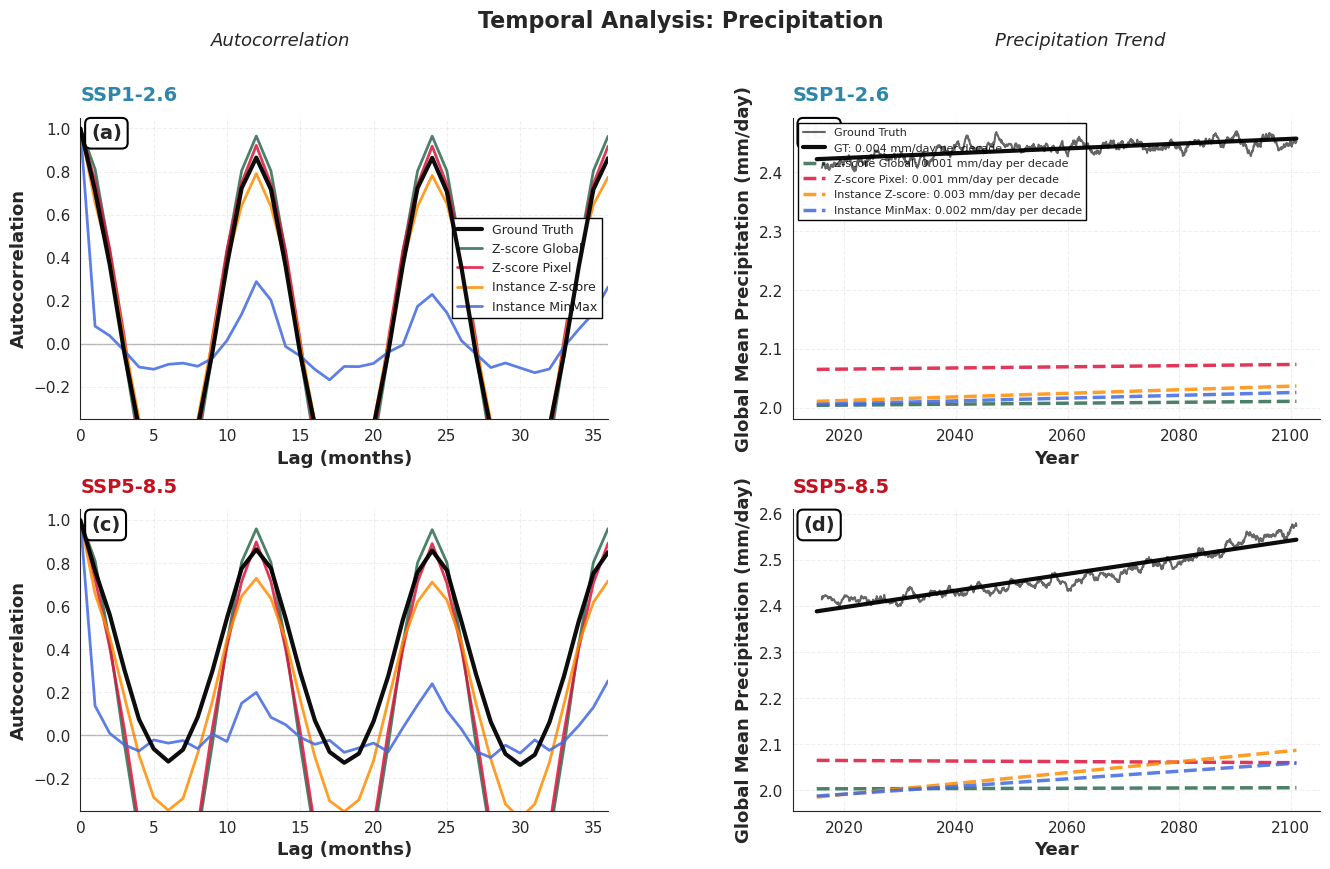

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import seaborn as sns
from scipy import stats

# Set style
sns.set_style("white")

# Load evaluation results
eval_dir = Path("evaluation_results")
scenarios = ['ssp126', 'ssp585']  # Only these two scenarios

# Load all scenario results
all_data = {}
for scenario in scenarios:
    ds = xr.open_dataset(eval_dir / f"pr_evaluation_{scenario}.nc")
    all_data[scenario] = ds

# Selected normalization methods only
norm_methods = ['zscore_global', 'zscore_pixel', 'instance_zscore', 'instance_minmax']

# Model labels for display
model_labels = {
    'zscore_global': 'Z-score Global',
    'zscore_pixel': 'Z-score Pixel',
    'instance_zscore': 'Instance Z-score',
    'instance_minmax': 'Instance MinMax'
}

# Colors for each model
model_colors = {
    'zscore_global': '#2D6A4F',      # Forest Green
    'zscore_pixel': '#DC143C',       # Crimson
    'instance_zscore': '#FF8C00',    # Dark Orange
    'instance_minmax': '#4169E1'     # Royal Blue
}

# Scenario labels
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp585': 'SSP5-8.5'
}

# Scenario colors
scenario_colors = {
    'ssp126': '#2E86AB',
    'ssp585': '#C1121F'
}

def calc_global_mean(data):
    """Calculate global mean time series"""
    if isinstance(data, xr.DataArray):
        return data.mean(dim=['lat', 'lon']).values
    else:
        return np.mean(data, axis=(1, 2))

def calculate_autocorrelation(time_series, max_lag=36):
    """
    Calculate temporal autocorrelation function.
    
    Parameters:
    - time_series: 1D array of values over time
    - max_lag: maximum lag to calculate (in time steps)
    
    Returns:
    - lags: array of lag values
    - acf: autocorrelation values
    """
    n = len(time_series)
    mean = np.mean(time_series)
    var = np.var(time_series)
    
    acf = np.zeros(max_lag + 1)
    for lag in range(max_lag + 1):
        if lag == 0:
            acf[lag] = 1.0
        else:
            c0 = np.sum((time_series[:n-lag] - mean) * (time_series[lag:] - mean))
            acf[lag] = c0 / (var * (n - lag))
    
    lags = np.arange(max_lag + 1)
    return lags, acf

def calculate_trend(time_series, time_coords):
    """
    Calculate linear trend using least squares regression.
    
    Parameters:
    - time_series: 1D array of values over time
    - time_coords: time coordinates (e.g., years)
    
    Returns:
    - slope: trend in units per time unit (e.g., mm/day per year)
    - intercept: intercept of trend line
    - r_value: correlation coefficient
    - p_value: p-value for hypothesis test
    """
    # Remove NaN values
    mask = ~np.isnan(time_series)
    x = time_coords[mask]
    y = time_series[mask]
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    
    return slope, intercept, r_value, p_value

# Create figure: 2 rows (scenarios) x 2 columns (autocorrelation + trend)
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.35)

# Store trend statistics for summary table
trend_stats = {}

for row_idx, scenario in enumerate(scenarios):
    ds = all_data[scenario]
    gt_data = ds['groundtruth'].values
    time = ds.time
    
    # Convert time to decimal years for trend analysis
    years = time.dt.year.values + time.dt.month.values / 12.0
    
    # Get ground truth global mean time series
    gt_mean = calc_global_mean(gt_data)
    
    # Calculate ground truth autocorrelation
    lags, gt_acf = calculate_autocorrelation(gt_mean, max_lag=36)
    
    # Calculate ground truth trend
    gt_slope, gt_intercept, gt_r, gt_p = calculate_trend(gt_mean, years)
    
    trend_stats[scenario] = {'Ground Truth': {
        'slope': gt_slope,
        'r_value': gt_r,
        'p_value': gt_p
    }}
    
    # Left column: Autocorrelation
    ax_acf = fig.add_subplot(gs[row_idx, 0])
    
    # Plot ground truth ACF with thick line
    ax_acf.plot(lags, gt_acf, color='black', linewidth=3, 
               label='Ground Truth', alpha=0.95, zorder=20)
    
    # Plot predictions ACF
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Calculate autocorrelation
            _, pred_acf = calculate_autocorrelation(pred_mean, max_lag=36)
            
            ax_acf.plot(lags, pred_acf, 
                       color=model_colors[norm_method],
                       linewidth=2, alpha=0.85,
                       label=model_labels[norm_method])
    
    # Format ACF plot
    ax_acf.set_xlabel('Lag (months)', fontsize=13, fontweight='bold')
    ax_acf.set_ylabel('Autocorrelation', fontsize=13, fontweight='bold')
    ax_acf.set_title(f'{scenario_labels[scenario]}', 
                    fontsize=14, fontweight='bold', color=scenario_colors[scenario], 
                    pad=12, loc='left')
    ax_acf.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax_acf.set_ylim(-0.35, 1.05)
    ax_acf.axhline(y=0, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax_acf.set_xlim(0, 36)
    
    # Add legend
    if row_idx == 0:
        ax_acf.legend(loc='center right', fontsize=9, framealpha=0.98, 
                     edgecolor='black', fancybox=False, bbox_to_anchor=(1.0, 0.5))
    
    ax_acf.tick_params(labelsize=11)
    ax_acf.spines['top'].set_visible(False)
    ax_acf.spines['right'].set_visible(False)
    
    # Right column: Trend Analysis
    ax_trend = fig.add_subplot(gs[row_idx, 1])
    
    # Calculate 12-month rolling mean for smoother visualization
    window = 12
    if len(gt_mean) >= window:
        gt_mean_smooth = np.convolve(gt_mean, np.ones(window)/window, mode='valid')
        years_smooth = years[window-1:]
    else:
        gt_mean_smooth = gt_mean
        years_smooth = years
    
    # Plot ground truth as LINE
    ax_trend.plot(years_smooth, gt_mean_smooth, color='black', linewidth=1.5, 
                 alpha=0.6, label='Ground Truth', zorder=18)
    
    # Plot ground truth trend line
    gt_trend_line = gt_slope * years + gt_intercept
    ax_trend.plot(years, gt_trend_line, 'k-', linewidth=3, alpha=0.95,
                 label=f'GT: {gt_slope*10:.3f} mm/day per decade', zorder=19)
    
    # Plot predictions with trend lines
    for norm_method in norm_methods:
        pred_key = f'pred_{norm_method}'
        if pred_key in ds:
            pred_data = ds[pred_key].values
            pred_mean = calc_global_mean(pred_data)
            
            # Calculate trend
            pred_slope, pred_intercept, pred_r, pred_p = calculate_trend(pred_mean, years)
            
            # Store trend stats
            trend_stats[scenario][norm_method] = {
                'slope': pred_slope,
                'r_value': pred_r,
                'p_value': pred_p
            }
            
            # Plot trend line only
            pred_trend_line = pred_slope * years + pred_intercept
            ax_trend.plot(years, pred_trend_line, 
                         color=model_colors[norm_method],
                         linewidth=2.5, alpha=0.85,
                         linestyle='--',
                         label=f'{model_labels[norm_method]}: {pred_slope*10:.3f} mm/day per decade')
    
    # Format trend plot
    ax_trend.set_xlabel('Year', fontsize=13, fontweight='bold')
    ax_trend.set_ylabel('Global Mean Precipitation (mm/day)', fontsize=13, fontweight='bold')
    ax_trend.set_title(f'{scenario_labels[scenario]}', 
                      fontsize=14, fontweight='bold', color=scenario_colors[scenario], 
                      pad=12, loc='left')
    ax_trend.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    
    # Add legend
    if row_idx == 0:
        ax_trend.legend(loc='upper left', fontsize=8, framealpha=0.98,
                       edgecolor='black', fancybox=False, bbox_to_anchor=(0.0, 1.0))
    
    ax_trend.tick_params(labelsize=11)
    ax_trend.spines['top'].set_visible(False)
    ax_trend.spines['right'].set_visible(False)

# Add panel labels
axes = fig.get_axes()
panel_labels = ['(a)', '(b)', '(c)', '(d)']
for ax, label in zip(axes, panel_labels):
    ax.text(0.02, 0.98, label, transform=ax.transAxes,
           fontsize=14, fontweight='bold', va='top', ha='left',
           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                    edgecolor='black', linewidth=1.5))

# Overall title
fig.text(0.5, 0.98, 'Temporal Analysis: Precipitation', 
        ha='center', fontsize=16, fontweight='bold')
fig.text(0.25, 0.96, 'Autocorrelation', 
        ha='center', fontsize=13, style='italic')
fig.text(0.75, 0.96, 'Precipitation Trend', 
        ha='center', fontsize=13, style='italic')

plt.tight_layout(rect=[0, 0, 1, 0.95])

# # Save
# plt.savefig('temporal_analysis_pr.png', dpi=300, bbox_inches='tight', facecolor='white')
# plt.savefig('temporal_analysis_pr.pdf', bbox_inches='tight', facecolor='white')

plt.show()
